In [7]:
import os

#is the notebook running on Colab?
if 'COLAB_JUPYTER_TRANSPORT' in os.environ.keys():
    isColab = True
    sourcedir =os.getcwd()+ "/CPlantBox"
    filedir = sourcedir +"/tutorial/jupyter/fspm_2023"
else:
    isColab = False
    sourcedir = os.getcwd()+"/../../.."
    filedir = os.getcwd()
#this can take some minutes
if isColab:
    # downloading the source code
    ! git clone https://github.com/Plant-Root-Soil-Interactions-Modelling/CPlantBox --depth=1 --single-branch -b stable_v2.1
    os.chdir(sourcedir)
    !apt install libeigen3-dev
    ! apt install llvm-dev
    !pip3 install vtk
    !sudo DEBIAN_FRONTEND=noninteractive apt-get install -yq xvfb
    !pip install -q 'xvfbwrapper~=0.2.9'
    if 'vdisplay' not in globals():
        # start a virtual X display for MAGICAL rendering
        import xvfbwrapper
        vdisplay = xvfbwrapper.Xvfb()
        vdisplay.start()
    os.environ["CUDA_VISIBLE_DEVICES"] = "1"


    if os.path.exists("./src/external/pybind11"):
        ! rm -rf src/external/pybind11 #delete folder
    ! git rm -r --cached src/external/pybind11 #take out git cache for pybind11
    ! git submodule add --force -b stable https://github.com/pybind/pybind11.git ./src/external/pybind11


    ! git pull
    ! cmake .
    ! make
    os.chdir(filedir)
    
    from google.colab import drive
    drive.mount('/content/drive')

# Workshop 6.2024 - (2/4)

## Post-processing (how to evaluate simulation results)

Basically, there are two methods 

1. Using class *RootSystem* directly, parameter values are given per root (root system is represented as polylines).

2. Using class *SegmentAnalyser*, which will consider all segments of the root system, parameter values are given per segment (root system is represented by nodes and segments).


Furthermore, post-processing can be done per time step in a simulation loop (a), or on the final result (b). 

In [8]:
import sys; sys.path.append(sourcedir); sys.path.append(sourcedir+"/src")
import plantbox as pb
import visualisation.vtk_plot as vp # for quick vizualisations
import matplotlib.pyplot as plt # for 2d plots
import numpy as np

A typical simulation loop will look like

OrganRandomParameter::readSuccessor: for parameter of organ 2, subType 1, 'ruleId' (and 'number') not found in successor definition. Use defeault ruleId instead: 0
OrganRandomParameter::readSuccessor: for parameter of organ 2, subType 2, 'ruleId' (and 'number') not found in successor definition. Use defeault ruleId instead: 0
Seed::initialize: RootSystem 
Seed::initialize: Basal root type #4 was not defined, using tap root parameters instead


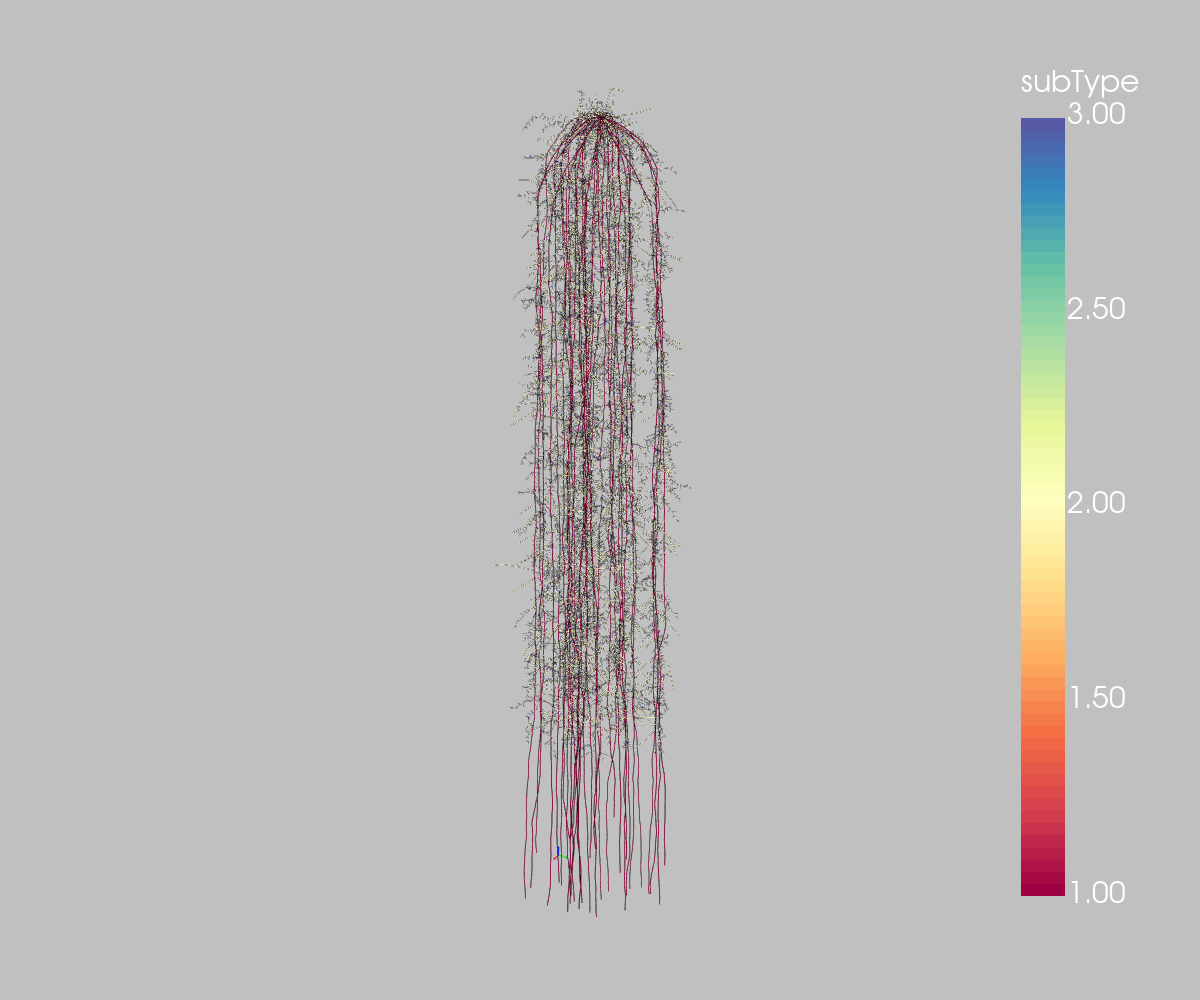

In [9]:
rs = pb.RootSystem()
path = "../../../modelparameter/structural/rootsystem/"
name = "Zea_mays_1_Leitner_2010"
rs.readParameters(path + name + ".xml")
rs.setGeometry(pb.SDF_PlantBox(1.e6,1.e6,1.e6)) 
rs.initialize()

""" Simulation loop """
simtime = 60.  # final simulation time [day]
dt = 1. # time step [day]
N = round(simtime / dt)  # number of iterations

for i in range(0, N):
    
    # Coupling to plant functional models or soil     
    
    rs.simulate(dt)
    
    # Coupling to plant functional models or soil 
    
    # Code for post-processing per time step (e.g. store relevant information in a list)
    

# Code for post-processing of the final result (write relevant results, e.g. csv, xls, etc.)
_  = vp.plot_roots(rs, "subType", interactiveImage = False) # Plot, using vtk

### 1a. Analyse results from the class *RootSystem* directly (values per root) in a loop

The following example will plot length versus time for the root system, and each subType (see *example2d_length.py*)

Seed::initialize: RootSystem 
Seed::initialize: Basal root type #4 was not defined, using tap root parameters instead


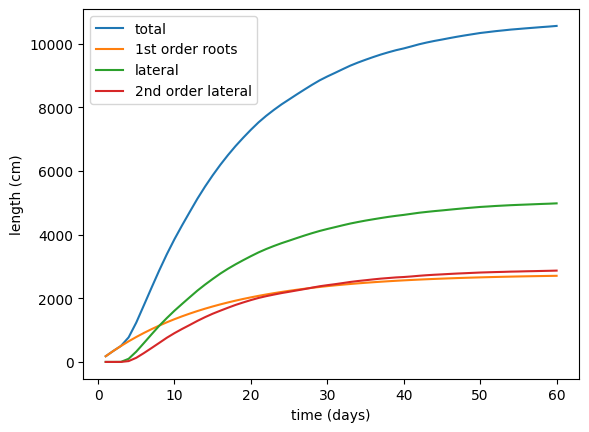

In [10]:
rs.initialize() # reset above simulation
scalar_type = "length" # "surface", "volume"
v_, v1_, v2_, v3_, v4_ = np.zeros(N), np.zeros(N), np.zeros(N), np.zeros(N), np.zeros(N)

""" Simulation loop """
for i in range(0, N):
    rs.simulate(dt)
    t = np.array(rs.getParameter("subType")) # value per root
    v = np.array(rs.getParameter(scalar_type)) # all random or specific parameters are accessible
    v_[i] = np.sum(v)
    v1_[i] = np.sum(v[t == 1])
    v2_[i] = np.sum(v[t == 2])
    v3_[i] = np.sum(v[t == 3])
    # v4_[i] = np.sum(v[t == 4])
    
t_ = np.linspace(dt, N * dt, N)
plt.plot(t_, v_, t_, v1_, t_, v2_, t_, v3_)
plt.xlabel("time (days)")
plt.ylabel(scalar_type + " (cm)")
plt.legend(["total", "1st order roots", "lateral", "2nd order lateral"])
# plt.savefig("myplot.png") # we could save it as png
plt.show()

### 1b. Analyse results from the class *RootSystem* directly (values per root), pure post-processing

Seed::initialize: RootSystem 
Seed::initialize: Basal root type #4 was not defined, using tap root parameters instead
Total length 10383.385739580173 cm


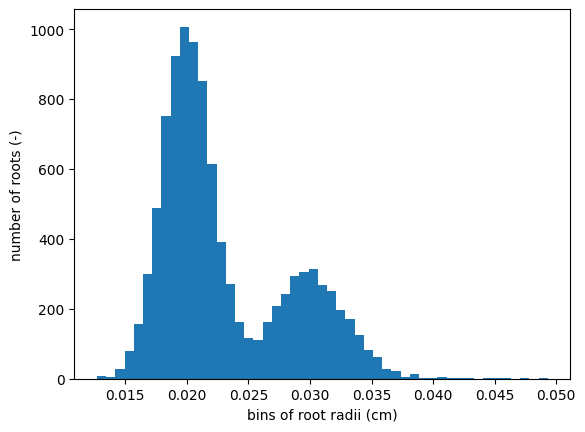

In [11]:
# Simulation
rs.initialize() # reset
rs.simulate(simtime)

# Post processing
print("Total length", np.sum(rs.getParameter("length")), "cm")

a = rs.getParameter("radius")
_ = plt.hist(a, bins='auto')
_ = plt.xlabel("bins of root radii (cm)")
_ = plt.ylabel("number of roots (-)")

# vp.plot_roots(rs, "subType") # Plot, using vtk 

It is possible to obtain all specific parameters of roots that have been created

In [12]:
p = []
roots = rs.getRoots()
for r in roots:
    p.append(r.param()) # Root.param() returns the RootSpecific parameters of the root
print(len(roots), "roots\n")
print(p[3]) # specific parameters of root 4

9998 roots

subType	3
lb	0
la	0.4
nob	0
r	2.04999
a	0.019395
theta	1.26107
rlt	9.78111e+08
ln	



## Take away messages

The function rs.getParameter(name) will help you to retrieve any parameters given per root (or per organ) for post-processing. 

## 2a. Analyse results from the class *SegmentAnalyser* (values per segment) in a loop

The main functionality of the *SegmentAnalyser* class is:
* *getParameter(name)* as for *RootSystem* class, but returning a value for each segment, especially the "creationTime" of each segment
* *filter(name, min, max)* will keep only segments where the value of parameter *name* is within [min, max]
* *crop(sdf)* will keep only segments inside a geometry (e.g. in a soil core), segments intersecting the domain boundary are cut. 
* *distribution(...)* will create a 1d plot versus depth, where parameters are summed in layers 
* *distribution2d(...)* as above but 2d
* *mapPeriodic(length, width)* maps the unconstrained root system into a periodic domain
* *addData(name, data)* attach user data to the segments (e.g. simulation results for visualization or export)

Note that *SegmentAnalyser* is only loosly connected to the original simulation.

The first example shows how to obtain a depth distribution (values per segment) in a simulation loop.

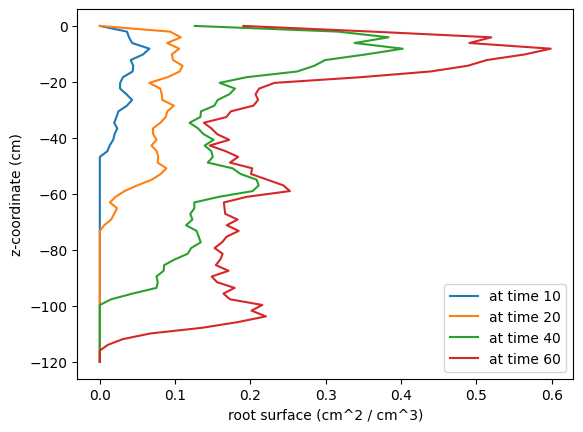

In [13]:
rs = pb.RootSystem()
path = "../../../modelparameter/structural/rootsystem/"
name = "Moraesetal_2018"
rs.readParameters(path + name + ".xml")
rs.setGeometry(pb.SDF_PlantBox(1.e6,1.e6,1.e6)) 
rs.initialize()

simtimes = [0,10,20,40,60] # day
dt_ = np.diff(simtimes) # day
depth = 120 # cm
layers = 60 # [1]

""" Simulation loop """
rsd_ = []
for dt in dt_:    
    rs.simulate(dt)
    # _ = vp.plot_roots(rs, "subType") # to observe growth
    ana = pb.SegmentAnalyser(rs) # create a SegmentAnalyser object
    rsd = ana.distribution("surface", 0., -depth, layers, True)
    rsd_.append(rsd) # store relevant data in a list

""" vizualize rld_ """
soilvolume = (depth / layers) * 10 * 10
rsd_ = np.array(rsd_) / soilvolume  # convert to density [cm2/cm3]

z_ = np.linspace(0, -depth, layers)  # z - axis
for i, t in enumerate(simtimes[1:]):
    plt.plot(rsd_[i,:], z_, label = "at time "+str(t))

plt.xlabel("root surface (cm^2 / cm^3)")
plt.ylabel("z-coordinate (cm)")
plt.legend()
# plt.savefig("surface_density.png")
plt.show()
# _ = vp.plot_roots(rs, "subType") # final result

To reduce noise we can use mean value and standard deviations of multiple simulation runs, see *example3a_density.py*

## 2b. Analyse results from the class *SegmentAnalyser* (values per segment), pure post-processing

Since the creation time (*creationTime*) of the segments is known, it is often sufficient to use pure post-processing when using the *SegmentAnalyser* class. The following example is based on *example3b_sdfanalysis.py* and shows the use of *mapPeriodic*, *filter()* and *crop()*.

First we map the root system to a periodic domain and visualize it:

Unconstrained:
Minimum of bounding box ( -18.1056, -25.2056, -113.685 )
Maximum of bounding box ( 22.4361, 31.325, 0 )

Periodic domain:
Minimum of bounding box ( -10, -5, -113.685 )
Maximum of bounding box ( 10, 5, 0 )


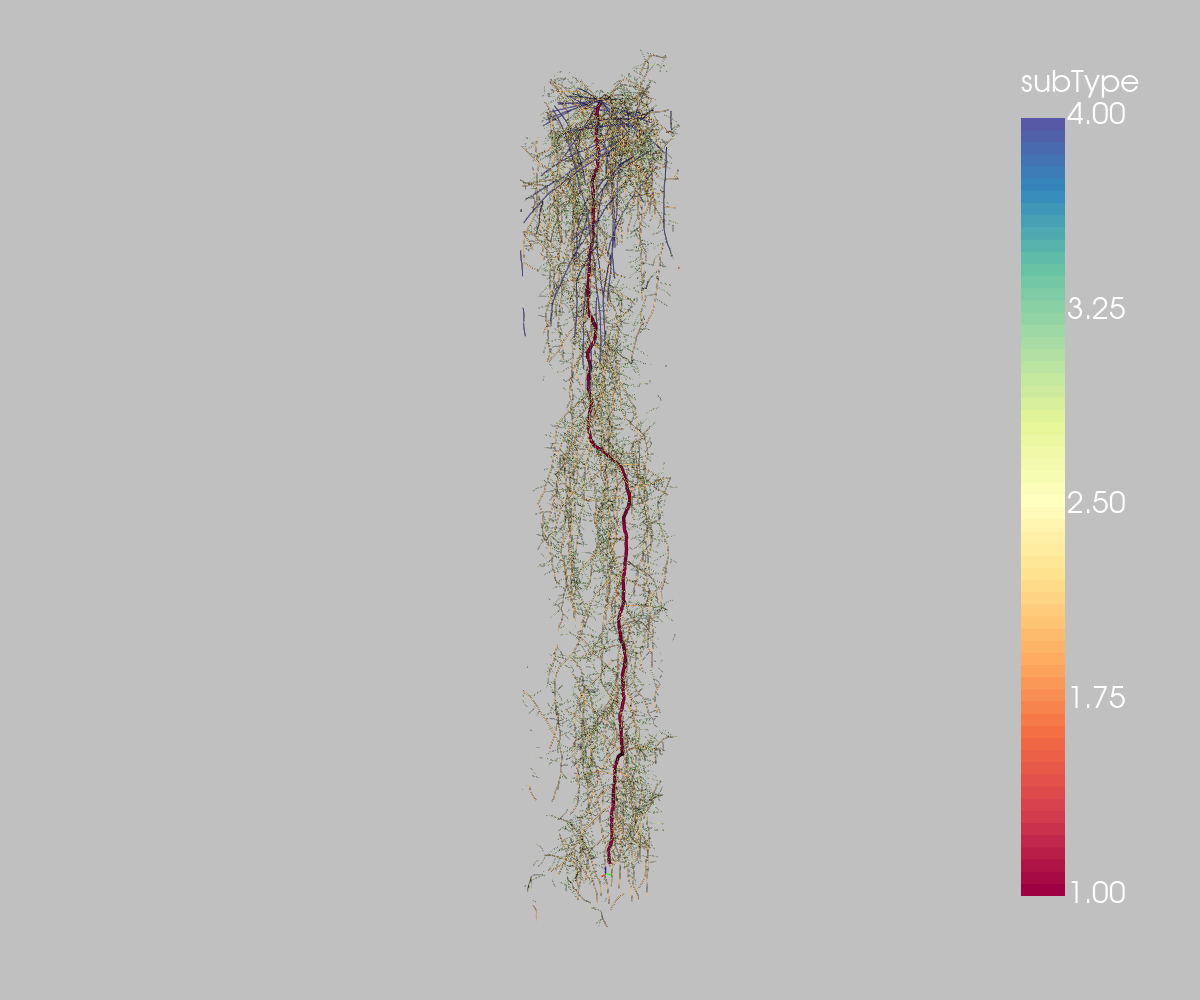

In [15]:
ana = pb.SegmentAnalyser(rs)
print("Unconstrained:")
print("Minimum of bounding box", ana.getMinBounds())
print("Maximum of bounding box", ana.getMaxBounds())
ana.mapPeriodic(20,10) # period in x and y direction [cm]
print("\nPeriodic domain:")
print("Minimum of bounding box", ana.getMinBounds())
print("Maximum of bounding box", ana.getMaxBounds())
_ = vp.plot_roots(ana, "subType", interactiveImage = False) # plots the periodic root system

Next we show a virtual coring experiment on the periodic setting:

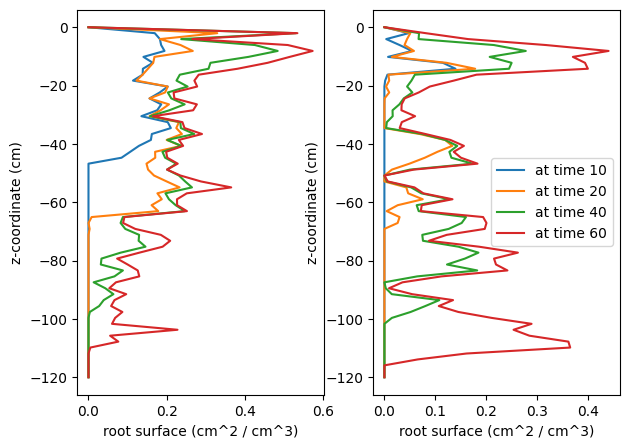

In [25]:
r, depth, layers = 2., 120., 60  # Soil core analysis
soilcore = pb.SDF_PlantContainer(r, r, depth, False)  # True = cubid, False = cylindric
soilcore2 = pb.SDF_RotateTranslate(soilcore, 0, 0, pb.Vector3d(4., 0, 0))  # shift for 4 cm in x-direction

simtimes =  [0,10,20,40,60] # day
rsd_, rsd2_ = [], []
for t in simtimes[1:]:
    a = pb.SegmentAnalyser(ana) # copy    
    a.filter("creationTime", 0, t) # keep segments with creation time in [0, time]
    a2 = pb.SegmentAnalyser(a)
    a.crop(soilcore)
    rsd = a.distribution("surface", 0., -depth, layers, True)
    rsd_.append(rsd)
    a2.crop(soilcore2)
    rsd2 = a2.distribution("surface", 0., -depth, layers, True)
    rsd2_.append(rsd2)

""" vizualize rsd_ """
soilvolume = (depth / layers) *r*r*np.pi
rsd_ = np.array(rsd_) / soilvolume  # convert to density [cm2/cm3]
rsd2_ = np.array(rsd2_) / soilvolume  # convert to density [cm2/cm3]

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(7, 5))
z_ = np.linspace(0, -depth, layers)  # z - axis
for i, t in enumerate(simtimes[1:]):
    ax1.plot(rsd_[i,:], z_, label = "at time "+str(t))
    ax2.plot(rsd2_[i,:], z_, label = "at time "+str(t))
    
ax1.set_xlabel("root surface (cm^2 / cm^3)")
ax1.set_ylabel("z-coordinate (cm)")
ax2.set_xlabel("root surface (cm^2 / cm^3)")
ax2.set_ylabel("z-coordinate (cm)")

plt.legend()
# plt.savefig("surface_density.png")
plt.show()

### (b.3) Exporting data 

see *example3c_write.py*, and *example3e_animation.py* for creating an animation.

In [26]:
rs.write("as_polylines.vtp") # nicer tube plots in Paraview, but cannot map to segments

ana = pb.SegmentAnalyser(rs)
ana.write("as_segments.vtp") # coarser tube plots, but values per segment (e.g. for animation)
    
ana.mapPeriodic(20, 10) # or crop, or filter, ...
ana.write("periodic_domain.vtp") 

#
# Geometry: 
# we can use RootSystem class to write a Paraview macro 
# set operations will not be calculated for the export 
#
periodic_domain = pb.SDF_PlantBox(20, 10, 120) # [cm]
soilcore = pb.SDF_PlantContainer(r, r, depth, False)  # 
soilcore2 = pb.SDF_RotateTranslate(soilcore, 0, 0, pb.Vector3d(4., 0, 0)) # shift for 4 cm
rs.setGeometry(pb.SDF_Union([periodic_domain, soilcore, soilcore2])) #
rs.write("geometry.py")

OrganRandomParameter::readSuccessor: for parameter of organ 2, subType 1, 'ruleId' (and 'number') not found in successor definition. Use defeault ruleId instead: 0
OrganRandomParameter::readSuccessor: for parameter of organ 2, subType 2, 'ruleId' (and 'number') not found in successor definition. Use defeault ruleId instead: 0
OrganRandomParameter::readSuccessor: for parameter of organ 2, subType 3, 'ruleId' (and 'number') not found in successor definition. Use defeault ruleId instead: 0
OrganRandomParameter::readSuccessor: for parameter of organ 2, subType 4, 'ruleId' (and 'number') not found in successor definition. Use defeault ruleId instead: 0
Seed::initialize: RootSystem 
writing VTP... as_polylines.vtp
writing VTP: as_segments.vtp
writing VTP: periodic_domain.vtp


Visualisations can be done in ParaView

## Take away messages

The *SegmentAnalyser* class will 

* retrieve parameter values per segment 
* analyse spatial layout of the root system (e.g. distribution, crop)
* give a representation of the root system consisting of segments and nodes, where each segment consists of two node indices